# Neural Networks from Scratch with NumPy

## A  Journey into Deep Learning Fundamentals

---

Welcome to this comprehensive tutorial where we'll build a neural network **completely from scratch** using only NumPy. No TensorFlow, no PyTorch - just pure mathematics and Python.

### What You'll Learn

| Chapter | Topic | Key Concepts |
|---------|-------|-------------|
| 1 | The Neuron | Biological inspiration, mathematical model |
| 2 | Activation Functions | Non-linearity, gradients, choosing activations |
| 3 | Forward Propagation | How data flows through the network |
| 4 | Loss Functions | Measuring how wrong we are |
| 5 | Backpropagation | The magic of learning (chain rule) |
| 6 | Building the Network | Putting it all together |
| 7 | Training & Visualization | Watch it learn! |

---

*"What I cannot create, I do not understand."* - Richard Feynman

In [ ]:
# ============================================================================
#                          IMPORTS & SETUP
# ============================================================================
# We only need NumPy for the math and Matplotlib for visualization.
# That's the beauty of building from scratch!
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable, Optional
from abc import ABC, abstractmethod

# Set random seed for reproducibility
np.random.seed(42)

# Beautiful plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Ready to build neural networks from scratch!")

Ready to build neural networks from scratch!


---

# Chapter 1: The Neuron - Where It All Begins

## From Biology to Mathematics

A biological neuron receives signals through **dendrites**, processes them in the **cell body**, and sends output through the **axon**. We model this mathematically:

```
        x  ----w----\
         1        1  \
        x  ----w-----> [  +  ] ---> activation ---> output
         2        2  /    ^    
        x  ----w----/     |
         3        3      bias
```

### The Mathematical Model

$$z = \sum_{i=1}^{n} w_i \cdot x_i + b = \mathbf{w}^T \mathbf{x} + b$$

$$a = \sigma(z)$$

Where:
- $\mathbf{x}$ = input features
- $\mathbf{w}$ = weights (learnable)
- $b$ = bias (learnable)
- $\sigma$ = activation function
- $a$ = output activation

In [ ]:
# ============================================================================
#                     A SINGLE NEURON - THE BUILDING BLOCK
# ============================================================================

def single_neuron(inputs: np.ndarray, weights: np.ndarray, bias: float) -> float:
    """
    Compute the output of a single neuron.

    This is the fundamental operation in neural networks:
    1. Multiply each input by its corresponding weight
    2. Sum all the weighted inputs
    3. Add the bias

    Parameters
    ----------
    inputs : array of shape (n_features,)
        The input values to the neuron
    weights : array of shape (n_features,)
        The weights for each input connection
    bias : float
        The bias term (like an adjustable threshold)

    Returns
    -------
    float : The weighted sum (before activation)
    """
    # The dot product elegantly computes: w1*x1 + w2*x2 + ... + wn*xn
    weighted_sum = np.dot(inputs, weights) + bias
    return weighted_sum


# Let's see it in action!
inputs = np.array([1.0, 2.0, 3.0])    # Three input features
weights = np.array([0.2, 0.8, -0.5])  # Connection strengths
bias = 2.0                             # Bias term

output = single_neuron(inputs, weights, bias)

print("A Single Neuron in Action")
print("=" * 40)
print(f"Inputs:  {inputs}")
print(f"Weights: {weights}")
print(f"Bias:    {bias}")
print(f"")
print(f"Calculation: ({inputs[0]}*{weights[0]}) + ({inputs[1]}*{weights[1]}) + ({inputs[2]}*{weights[2]}) + {bias}")
print(f"           = {inputs[0]*weights[0]} + {inputs[1]*weights[1]} + {inputs[2]*weights[2]} + {bias}")
print(f"           = {output}")

A Single Neuron in Action
Inputs:  [1. 2. 3.]
Weights: [ 0.2  0.8 -0.5]
Bias:    2.0

Calculation: (1.0*0.2) + (2.0*0.8) + (3.0*-0.5) + 2.0
           = 0.2 + 1.6 + -1.5 + 2.0
           = 2.3


---

# Chapter 2: Activation Functions - Adding Non-Linearity

## Why Do We Need Activation Functions?

Without activation functions, a neural network would just be a series of linear transformations. No matter how many layers, the output would still be a linear function of the input!

$$\text{Linear} \circ \text{Linear} = \text{Linear}$$

Activation functions introduce **non-linearity**, allowing networks to learn complex patterns.

### The Activation Function Zoo

| Function | Formula | Range | Best For |
|----------|---------|-------|----------|
| Sigmoid | $\frac{1}{1+e^{-x}}$ | (0, 1) | Binary classification output |
| Tanh | $\frac{e^x - e^{-x}}{e^x + e^{-x}}$ | (-1, 1) | Hidden layers (centered) |
| ReLU | $\max(0, x)$ | [0, +inf) | Hidden layers (most popular) |
| Leaky ReLU | $\max(0.01x, x)$ | (-inf, +inf) | Avoiding dead neurons |
| Softmax | $\frac{e^{x_i}}{\sum_j e^{x_j}}$ | (0, 1) | Multi-class output |

In [ ]:
# ============================================================================
#                         ACTIVATION FUNCTIONS
# ============================================================================
# Each activation function needs both:
#   1. The forward pass (compute output)
#   2. The derivative (for backpropagation)
# ============================================================================

class Activation(ABC):
    """
    Abstract base class for activation functions.

    Every activation function must implement:
    - forward: compute the activation
    - derivative: compute the gradient for backprop
    """

    @abstractmethod
    def forward(self, x: np.ndarray) -> np.ndarray:
        """Apply the activation function."""
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        """Compute the derivative for backpropagation."""
        pass

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.forward(x)


# -------------------------------- SIGMOID --------------------------------
class Sigmoid(Activation):
    """
    Sigmoid activation: squashes values to (0, 1)

             1
    f(x) = --------
           1 + e^(-x)

    Derivative: f'(x) = f(x) * (1 - f(x))

    Properties:
    - Output interpretable as probability
    - Suffers from vanishing gradients for large |x|
    - Not zero-centered
    """

    def forward(self, x: np.ndarray) -> np.ndarray:
        # Clip to prevent overflow in exp
        x_clipped = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x_clipped))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        s = self.forward(x)
        return s * (1 - s)  # Beautiful property of sigmoid!


# --------------------------------- TANH ----------------------------------
class Tanh(Activation):
    """
    Hyperbolic tangent: squashes values to (-1, 1)

           e^x - e^(-x)
    f(x) = -------------
           e^x + e^(-x)

    Derivative: f'(x) = 1 - f(x)^2

    Properties:
    - Zero-centered (better than sigmoid)
    - Still has vanishing gradient problem
    - Stronger gradients than sigmoid
    """

    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(x) ** 2


# --------------------------------- ReLU ----------------------------------
class ReLU(Activation):
    """
    Rectified Linear Unit: the most popular activation

    f(x) = max(0, x)

    Derivative: f'(x) = 1 if x > 0 else 0

    Properties:
    - Computationally efficient
    - No vanishing gradient for positive values
    - Can cause "dead neurons" (always output 0)
    - Not zero-centered
    """

    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return (x > 0).astype(float)


# ------------------------------ LEAKY ReLU ------------------------------
class LeakyReLU(Activation):
    """
    Leaky ReLU: ReLU with a small slope for negative values

    f(x) = x if x > 0 else alpha * x

    Properties:
    - Prevents dead neurons
    - Small negative slope keeps gradients flowing
    """

    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, x, self.alpha * x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, 1, self.alpha)


# -------------------------------- SOFTMAX --------------------------------
class Softmax(Activation):
    """
    Softmax: converts logits to probability distribution

                e^(x_i)
    f(x)_i = -----------
             sum(e^(x_j))

    Properties:
    - Output sums to 1 (valid probability distribution)
    - Used for multi-class classification output
    - Paired with cross-entropy loss
    """

    def forward(self, x: np.ndarray) -> np.ndarray:
        # Subtract max for numerical stability (prevents overflow)
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        # For softmax + cross-entropy, we typically combine them
        # The gradient is simply (softmax_output - target)
        # This is a simplified version
        s = self.forward(x)
        return s * (1 - s)


print("Activation functions loaded!")

Activation functions loaded!


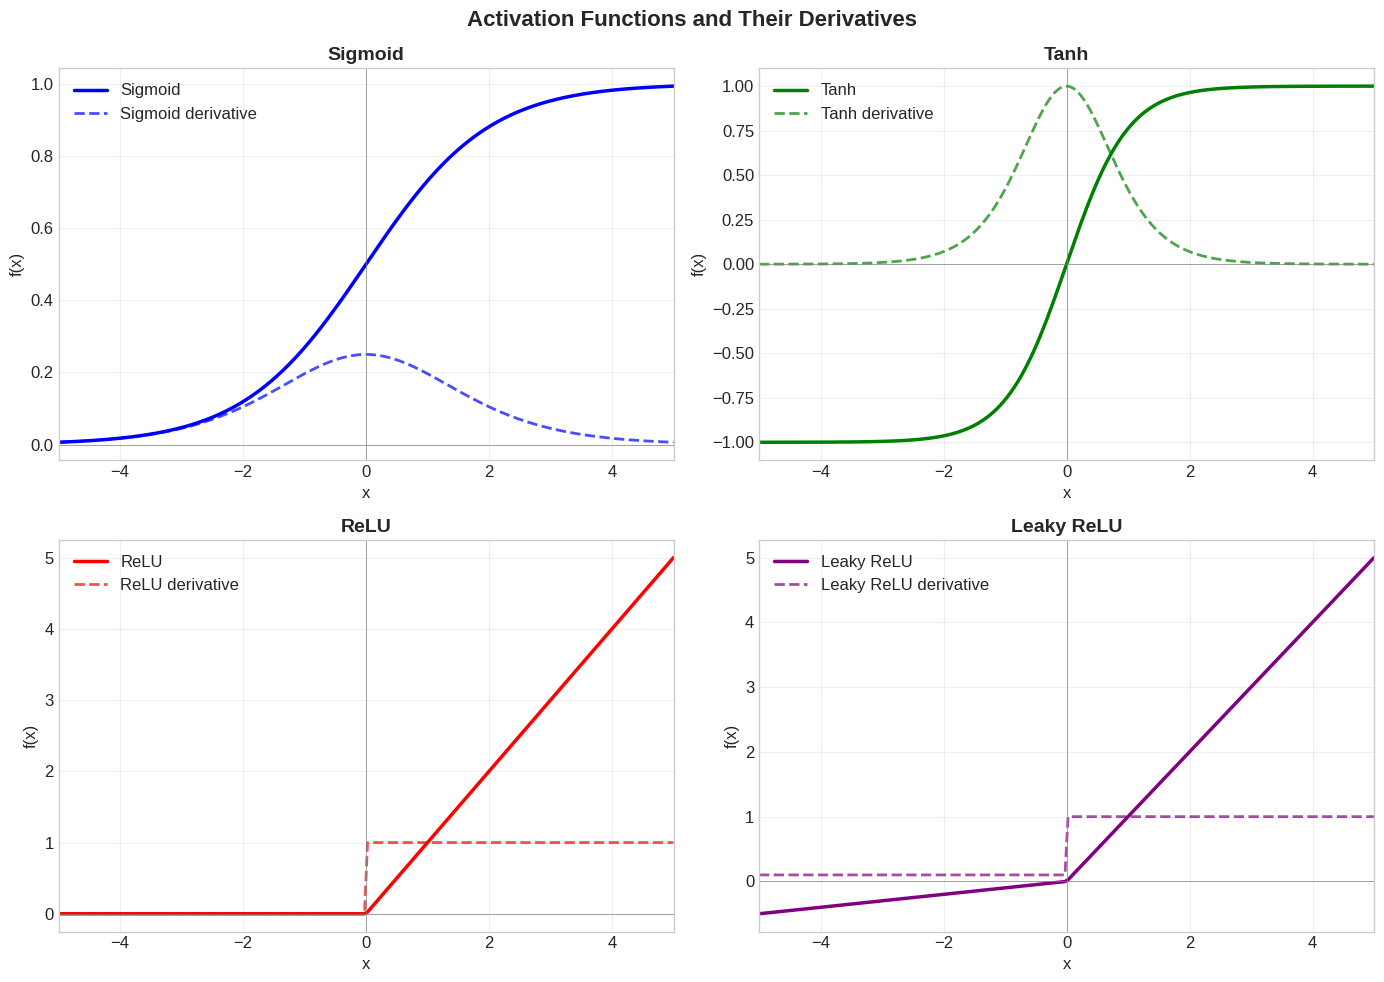


 Key Observations:
 Sigmoid/Tanh: Smooth but saturate (flat gradients at extremes)
 ReLU: Simple and effective, but 'dies' for negative inputs
 Leaky ReLU: Keeps small gradient for negative values


In [ ]:
# ============================================================================
#                    VISUALIZING ACTIVATION FUNCTIONS
# ============================================================================

x = np.linspace(-5, 5, 200)

activations = [
    ('Sigmoid', Sigmoid(), 'blue'),
    ('Tanh', Tanh(), 'green'),
    ('ReLU', ReLU(), 'red'),
    ('Leaky ReLU', LeakyReLU(0.1), 'purple')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Activation Functions and Their Derivatives', fontsize=16, fontweight='bold')

for ax, (name, activation, color) in zip(axes.flatten(), activations):
    y = activation.forward(x)
    dy = activation.derivative(x)

    ax.plot(x, y, color=color, linewidth=2.5, label=f'{name}')
    ax.plot(x, dy, color=color, linewidth=2, linestyle='--', alpha=0.7, label=f'{name} derivative')
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.set_xlim(-5, 5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print(" Sigmoid/Tanh: Smooth but saturate (flat gradients at extremes)")
print(" ReLU: Simple and effective, but 'dies' for negative inputs")
print(" Leaky ReLU: Keeps small gradient for negative values")

---

# Chapter 3: Loss Functions - Measuring Our Mistakes

## How Do We Know If We're Wrong?

A **loss function** (or cost function) quantifies how far our predictions are from the true values. During training, we want to **minimize** this loss.

### Common Loss Functions

**Mean Squared Error (MSE)** - for regression:
$$\mathcal{L}_{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

**Binary Cross-Entropy** - for binary classification:
$$\mathcal{L}_{BCE} = -\frac{1}{n} \sum_{i=1}^{n} [y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)]$$

**Categorical Cross-Entropy** - for multi-class classification:
$$\mathcal{L}_{CCE} = -\frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$$

In [ ]:
# ============================================================================
#                           LOSS FUNCTIONS
# ============================================================================

class Loss(ABC):
    """
    Abstract base class for loss functions.

    Loss functions measure the discrepancy between predictions and targets.
    They must provide both the loss value and the gradient for backprop.
    """

    @abstractmethod
    def forward(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        """Compute the loss value."""
        pass

    @abstractmethod
    def backward(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        """Compute the gradient of the loss w.r.t. predictions."""
        pass

    def __call__(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return self.forward(y_pred, y_true)


# ------------------------------ MSE Loss --------------------------------
class MSELoss(Loss):
    """
    Mean Squared Error Loss

    L = (1/n) * sum((y_pred - y_true)^2)

    Gradient: dL/dy_pred = (2/n) * (y_pred - y_true)

    Best for:
    - Regression problems
    - When you want to penalize large errors heavily
    """

    def forward(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        n = y_true.shape[0]
        return (2 / n) * (y_pred - y_true)


# ------------------------- Binary Cross-Entropy -------------------------
class BinaryCrossEntropyLoss(Loss):
    """
    Binary Cross-Entropy Loss

    L = -(1/n) * sum(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))

    Best for:
    - Binary classification
    - Output layer with sigmoid activation
    """

    def forward(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        # Clip predictions to prevent log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        n = y_true.shape[0]
        return (1 / n) * (-(y_true / y_pred) + (1 - y_true) / (1 - y_pred))


# ----------------------- Categorical Cross-Entropy -----------------------
class CategoricalCrossEntropyLoss(Loss):
    """
    Categorical Cross-Entropy Loss

    L = -(1/n) * sum(sum(y_true * log(y_pred)))

    Best for:
    - Multi-class classification
    - Output layer with softmax activation

    Note: When combined with softmax, gradient simplifies to (y_pred - y_true)
    """

    def forward(self, y_pred: np.ndarray, y_true: np.ndarray) -> float:
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=-1))

    def backward(self, y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
        # Simplified gradient for softmax + cross-entropy
        n = y_true.shape[0]
        return (y_pred - y_true) / n


print("Loss functions loaded!")

Loss functions loaded!


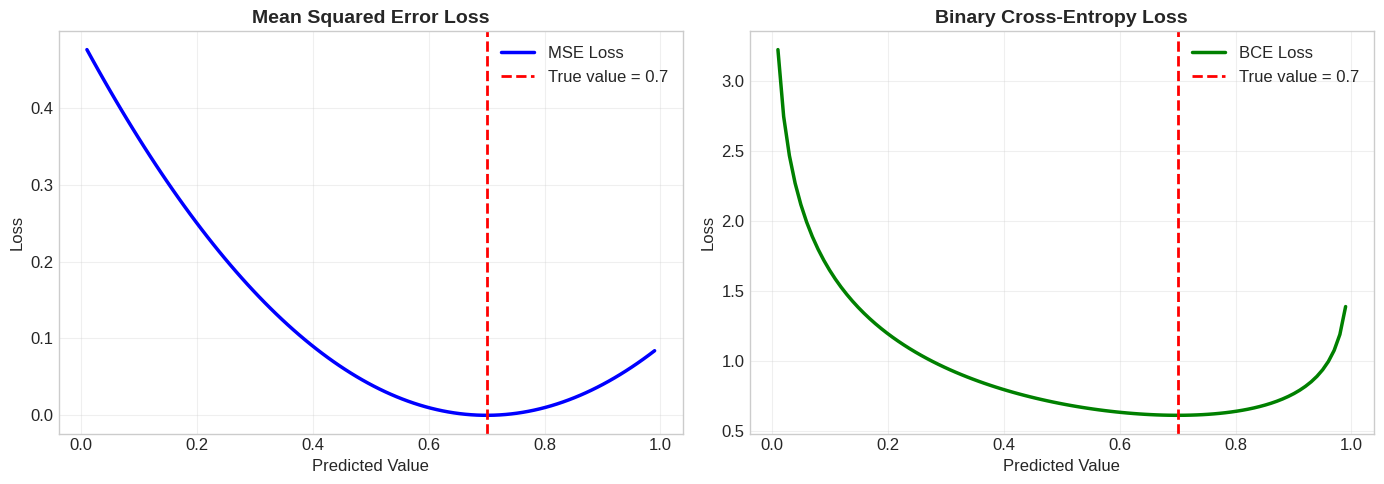


 Key Observations:
 MSE: Symmetric, quadratic shape
 BCE: Asymmetric, penalizes confident wrong predictions heavily


In [ ]:
# ============================================================================
#                     VISUALIZING LOSS LANDSCAPES
# ============================================================================

# Let's see how MSE loss behaves
y_true = 0.7  # True value
y_preds = np.linspace(0.01, 0.99, 100)

mse_loss = MSELoss()
bce_loss = BinaryCrossEntropyLoss()

mse_values = [mse_loss(np.array([y]), np.array([y_true])) for y in y_preds]
bce_values = [bce_loss(np.array([y]), np.array([y_true])) for y in y_preds]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MSE Loss
ax1.plot(y_preds, mse_values, 'b-', linewidth=2.5, label='MSE Loss')
ax1.axvline(x=y_true, color='red', linestyle='--', linewidth=2, label=f'True value = {y_true}')
ax1.set_xlabel('Predicted Value', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Mean Squared Error Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Binary Cross-Entropy Loss
ax2.plot(y_preds, bce_values, 'g-', linewidth=2.5, label='BCE Loss')
ax2.axvline(x=y_true, color='red', linestyle='--', linewidth=2, label=f'True value = {y_true}')
ax2.set_xlabel('Predicted Value', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Binary Cross-Entropy Loss', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print(" MSE: Symmetric, quadratic shape")
print(" BCE: Asymmetric, penalizes confident wrong predictions heavily")

---

# Chapter 4: The Dense Layer - Neurons Working Together

## From Single Neuron to Layer

A **Dense** (or Fully Connected) layer connects every input to every neuron:

```
Input Layer          Dense Layer
                    (3 neurons)
   x   =============> n   
    1  =============>  1  
   x   =============> n   
    2  =============>  2  
   x   =============> n   
    3  =============>  3  
       \           /
        (weights)
```

### Matrix Form

Instead of computing each neuron separately, we use matrix multiplication:

$$\mathbf{Z} = \mathbf{X} \cdot \mathbf{W} + \mathbf{b}$$

$$\mathbf{A} = \sigma(\mathbf{Z})$$

Where:
- $\mathbf{X}$ has shape `(batch_size, input_features)`
- $\mathbf{W}$ has shape `(input_features, output_neurons)`
- $\mathbf{b}$ has shape `(output_neurons,)`
- $\mathbf{A}$ has shape `(batch_size, output_neurons)`

In [ ]:
# ============================================================================
#                              DENSE LAYER
# ============================================================================

class DenseLayer:
    """
    Fully Connected (Dense) Layer

    This is the workhorse of neural networks. Each neuron in this layer
    is connected to every input, creating a rich representation.

    Architecture:

        Input (n_in)     Weights (n_in x n_out)      Output (n_out)

           [x1]              [w11 w12 w13]              [a1]
           [x2]    @         [w21 w22 w23]     + b  =   [a2]
           [x3]              [w31 w32 w33]              [a3]

    Parameters
    ----------
    n_inputs : int
        Number of input features
    n_neurons : int
        Number of neurons (output features)
    activation : Activation
        Activation function to apply
    """

    def __init__(self, n_inputs: int, n_neurons: int, activation: Activation):
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        self.activation = activation

        # ----------------------------------------------------------------
        # WEIGHT INITIALIZATION - Very Important!
        # ----------------------------------------------------------------
        # We use He initialization for ReLU-like activations:
        #   W ~ N(0, sqrt(2/n_in))
        # This prevents vanishing/exploding gradients.
        # ----------------------------------------------------------------
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)
        self.biases = np.zeros((1, n_neurons))

        # Cache for backpropagation
        self.input = None       # Input to this layer
        self.z = None           # Pre-activation (weighted sum)
        self.output = None      # Post-activation

        # Gradients
        self.dweights = None    # Gradient of loss w.r.t. weights
        self.dbiases = None     # Gradient of loss w.r.t. biases

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass: compute layer output.

        Steps:
        1. Linear transformation: Z = X @ W + b
        2. Apply activation: A = activation(Z)

        Parameters
        ----------
        X : array of shape (batch_size, n_inputs)

        Returns
        -------
        array of shape (batch_size, n_neurons)
        """
        self.input = X

        # Linear transformation: Z = X @ W + b
        self.z = np.dot(X, self.weights) + self.biases

        # Apply activation function
        self.output = self.activation.forward(self.z)

        return self.output

    def backward(self, dout: np.ndarray) -> np.ndarray:
        """
        Backward pass: compute gradients.

        This is where the magic of backpropagation happens!

        Using the chain rule:
        - dL/dW = dL/dA * dA/dZ * dZ/dW = dL/dZ * X^T
        - dL/db = sum(dL/dZ, axis=0)
        - dL/dX = dL/dZ * W^T  (pass to previous layer)

        Parameters
        ----------
        dout : array of shape (batch_size, n_neurons)
            Gradient flowing back from the next layer

        Returns
        -------
        array of shape (batch_size, n_inputs)
            Gradient to pass to the previous layer
        """
        # Gradient through activation function
        dz = dout * self.activation.derivative(self.z)

        # Gradient w.r.t. weights: dL/dW = X^T @ dZ
        self.dweights = np.dot(self.input.T, dz)

        # Gradient w.r.t. biases: dL/db = sum(dZ, axis=0)
        self.dbiases = np.sum(dz, axis=0, keepdims=True)

        # Gradient to pass to previous layer: dL/dX = dZ @ W^T
        dinput = np.dot(dz, self.weights.T)

        return dinput

    def __repr__(self):
        return f"DenseLayer({self.n_inputs} -> {self.n_neurons}, {self.activation.__class__.__name__})"


# Quick test!
layer = DenseLayer(3, 4, ReLU())
X = np.array([[1, 2, 3], [4, 5, 6]])  # 2 samples, 3 features
output = layer.forward(X)

print("Dense Layer Test")
print("=" * 40)
print(f"Layer: {layer}")
print(f"Input shape:  {X.shape}")
print(f"Output shape: {output.shape}")
print(f"\nWeights shape: {layer.weights.shape}")
print(f"Biases shape:  {layer.biases.shape}")

Dense Layer Test
Layer: DenseLayer(3 -> 4, ReLU)
Input shape:  (2, 3)
Output shape: (2, 4)

Weights shape: (3, 4)
Biases shape:  (1, 4)


---

# Chapter 5: Backpropagation - The Heart of Learning

## How Does a Network Learn?

Learning = Adjusting weights to minimize loss

We need to know: **How much does each weight contribute to the error?**

### The Chain Rule

Backpropagation uses the chain rule to propagate gradients backward:

$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial w}$$

```
Forward Pass:   x  -->  z = wx + b  -->  a = f(z)  -->  L(a, y)
                        
Backward Pass:       dL/dw  <--  dL/dz  <--  dL/da  <--  dL/dL = 1
```

### Gradient Descent Update

Once we have gradients, we update weights:

$$w_{new} = w_{old} - \eta \cdot \frac{\partial L}{\partial w}$$

Where $\eta$ is the **learning rate** (how big of a step we take).

In [ ]:
# ============================================================================
#                              OPTIMIZERS
# ============================================================================
# Optimizers update the weights using the computed gradients.
# Different optimizers have different strategies for this.
# ============================================================================

class Optimizer(ABC):
    """Abstract base class for optimizers."""

    @abstractmethod
    def update(self, layers: List[DenseLayer]) -> None:
        """Update the weights of all layers."""
        pass


class SGD(Optimizer):
    """
    Stochastic Gradient Descent

    The simplest optimizer:
    w = w - learning_rate * gradient

    With optional momentum:
    v = momentum * v - learning_rate * gradient
    w = w + v

    Momentum helps:
    - Accelerate in consistent gradient directions
    - Dampen oscillations
    - Escape shallow local minima
    """

    def __init__(self, learning_rate: float = 0.01, momentum: float = 0.0):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocities = {}  # Store velocity for each layer

    def update(self, layers: List[DenseLayer]) -> None:
        for i, layer in enumerate(layers):
            # Initialize velocities on first update
            if i not in self.velocities:
                self.velocities[i] = {
                    'w': np.zeros_like(layer.weights),
                    'b': np.zeros_like(layer.biases)
                }

            # Compute velocity with momentum
            self.velocities[i]['w'] = (
                self.momentum * self.velocities[i]['w'] -
                self.learning_rate * layer.dweights
            )
            self.velocities[i]['b'] = (
                self.momentum * self.velocities[i]['b'] -
                self.learning_rate * layer.dbiases
            )

            # Update weights
            layer.weights += self.velocities[i]['w']
            layer.biases += self.velocities[i]['b']


class Adam(Optimizer):
    """
    Adam Optimizer (Adaptive Moment Estimation)

    The most popular optimizer! Combines:
    - Momentum (first moment estimate)
    - RMSprop (second moment estimate - adaptive learning rates)

    Updates:
    m = beta1 * m + (1 - beta1) * gradient         # First moment
    v = beta2 * v + (1 - beta2) * gradient^2       # Second moment
    m_hat = m / (1 - beta1^t)                      # Bias correction
    v_hat = v / (1 - beta2^t)
    w = w - lr * m_hat / (sqrt(v_hat) + epsilon)
    """

    def __init__(
        self,
        learning_rate: float = 0.001,
        beta1: float = 0.9,
        beta2: float = 0.999,
        epsilon: float = 1e-8
    ):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0  # Time step
        self.m = {}  # First moment estimates
        self.v = {}  # Second moment estimates

    def update(self, layers: List[DenseLayer]) -> None:
        self.t += 1

        for i, layer in enumerate(layers):
            # Initialize moments on first update
            if i not in self.m:
                self.m[i] = {
                    'w': np.zeros_like(layer.weights),
                    'b': np.zeros_like(layer.biases)
                }
                self.v[i] = {
                    'w': np.zeros_like(layer.weights),
                    'b': np.zeros_like(layer.biases)
                }

            # Update weights
            for param, grad in [('w', layer.dweights), ('b', layer.dbiases)]:
                # Update biased first moment estimate
                self.m[i][param] = self.beta1 * self.m[i][param] + (1 - self.beta1) * grad
                # Update biased second moment estimate
                self.v[i][param] = self.beta2 * self.v[i][param] + (1 - self.beta2) * (grad ** 2)

                # Bias-corrected estimates
                m_hat = self.m[i][param] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i][param] / (1 - self.beta2 ** self.t)

                # Update parameter
                update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

                if param == 'w':
                    layer.weights -= update
                else:
                    layer.biases -= update


print("Optimizers loaded!")

Optimizers loaded!


---

# Chapter 6: The Complete Neural Network

## Putting It All Together

Now we combine everything into a beautiful, modular neural network class!

```
    Input         Hidden Layer 1     Hidden Layer 2      Output
    
    [x1] ----+-----> [h1] ----+-----> [h1'] ----+-----> [y1]
            /|\            /|\             /|\
    [x2] --/-+-\-> [h2] --/-+-\-> [h2'] --/-+-\-> [y2]
          / | \ \       / | \ \        / | \ \
    [x3] -+-+-+----> [h3] -+-+-+----> [h3'] -+-+-+----> [y3]
    
    "Fully connected" - every neuron connects to every neuron in next layer
```

In [ ]:
# ============================================================================
#                        THE NEURAL NETWORK CLASS
# ============================================================================

class NeuralNetwork:
    """
    A Feedforward Neural Network built from scratch.

                    THE ARCHITECTURE
    ================================================

    Input --> [Dense + Activation] x N --> Output

    Forward Pass:  Data flows left to right
    Backward Pass: Gradients flow right to left

    This class provides:
    - Easy layer stacking with .add()
    - Training with .fit()
    - Prediction with .predict()
    - Training history visualization

    Example
    -------
    >>> nn = NeuralNetwork(loss=MSELoss(), optimizer=Adam(lr=0.001))
    >>> nn.add(DenseLayer(2, 16, ReLU()))
    >>> nn.add(DenseLayer(16, 1, Sigmoid()))
    >>> nn.fit(X_train, y_train, epochs=100)
    """

    def __init__(self, loss: Loss, optimizer: Optimizer):
        """
        Initialize the neural network.

        Parameters
        ----------
        loss : Loss
            Loss function to optimize
        optimizer : Optimizer
            Optimizer for updating weights
        """
        self.layers: List[DenseLayer] = []
        self.loss = loss
        self.optimizer = optimizer
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    def add(self, layer: DenseLayer) -> 'NeuralNetwork':
        """
        Add a layer to the network.

        Returns self for method chaining:
        nn.add(layer1).add(layer2).add(layer3)
        """
        self.layers.append(layer)
        return self

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Forward pass: propagate input through all layers.

        X --> Layer 1 --> Layer 2 --> ... --> Output
        """
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def backward(self, y_true: np.ndarray) -> None:
        """
        Backward pass: compute gradients for all layers.

        This is where the learning happens!

        1. Compute loss gradient w.r.t. output
        2. Propagate gradient backward through layers
        3. Each layer computes its own weight gradients
        """
        # Get the network output (from last layer)
        y_pred = self.layers[-1].output

        # Compute gradient of loss w.r.t. output
        grad = self.loss.backward(y_pred, y_true)

        # Propagate gradient backward through all layers
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

    def fit(
        self,
        X: np.ndarray,
        y: np.ndarray,
        epochs: int = 100,
        batch_size: int = 32,
        validation_data: Optional[Tuple[np.ndarray, np.ndarray]] = None,
        verbose: bool = True
    ) -> dict:
        """
        Train the neural network.

        The Training Loop:

        for each epoch:
            for each batch:
                1. Forward pass  --> compute predictions
                2. Compute loss  --> how wrong are we?
                3. Backward pass --> compute gradients
                4. Update weights --> learn from mistakes

        Parameters
        ----------
        X : array of shape (n_samples, n_features)
            Training data
        y : array of shape (n_samples, n_outputs)
            Target values
        epochs : int
            Number of passes through the entire dataset
        batch_size : int
            Number of samples per gradient update
        validation_data : tuple, optional
            (X_val, y_val) for validation metrics
        verbose : bool
            Whether to print progress

        Returns
        -------
        dict : Training history
        """
        n_samples = X.shape[0]

        for epoch in range(epochs):
            # Shuffle data at the start of each epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            n_batches = 0

            # Mini-batch gradient descent
            for i in range(0, n_samples, batch_size):
                # Get batch
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Compute loss
                batch_loss = self.loss(y_pred, y_batch)
                epoch_loss += batch_loss
                n_batches += 1

                # Backward pass
                self.backward(y_batch)

                # Update weights
                self.optimizer.update(self.layers)

            # Record average loss for this epoch
            avg_loss = epoch_loss / n_batches
            self.history['loss'].append(avg_loss)

            # Compute accuracy
            train_acc = self._compute_accuracy(X, y)
            self.history['accuracy'].append(train_acc)

            # Validation metrics
            if validation_data is not None:
                X_val, y_val = validation_data
                val_pred = self.forward(X_val)
                val_loss = self.loss(val_pred, y_val)
                val_acc = self._compute_accuracy(X_val, y_val)
                self.history['val_loss'].append(val_loss)
                self.history['val_accuracy'].append(val_acc)

            # Print progress
            if verbose and (epoch + 1) % max(1, epochs // 10) == 0:
                msg = f"Epoch {epoch + 1:4d}/{epochs} | Loss: {avg_loss:.6f} | Acc: {train_acc:.4f}"
                if validation_data is not None:
                    msg += f" | Val Loss: {val_loss:.6f} | Val Acc: {val_acc:.4f}"
                print(msg)

        return self.history

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions for input data.
        """
        return self.forward(X)

    def _compute_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Compute classification accuracy.
        """
        predictions = self.predict(X)
        if predictions.shape[-1] == 1:  # Binary classification
            pred_classes = (predictions > 0.5).astype(int)
            true_classes = y.astype(int)
        else:  # Multi-class classification
            pred_classes = np.argmax(predictions, axis=-1)
            true_classes = np.argmax(y, axis=-1)
        return np.mean(pred_classes.flatten() == true_classes.flatten())

    def summary(self) -> None:
        """
        Print a summary of the network architecture.
        """
        print("\n" + "=" * 60)
        print("                    NETWORK SUMMARY")
        print("=" * 60)

        total_params = 0
        for i, layer in enumerate(self.layers):
            n_params = layer.weights.size + layer.biases.size
            total_params += n_params
            print(f"Layer {i + 1}: {layer}")
            print(f"         Params: {n_params:,} (W: {layer.weights.shape}, b: {layer.biases.shape})")

        print("-" * 60)
        print(f"Total Parameters: {total_params:,}")
        print(f"Loss Function:    {self.loss.__class__.__name__}")
        print(f"Optimizer:        {self.optimizer.__class__.__name__}")
        print("=" * 60 + "\n")

    def plot_history(self) -> None:
        """
        Plot training history.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Loss plot
        ax1.plot(self.history['loss'], 'b-', linewidth=2, label='Training Loss')
        if self.history['val_loss']:
            ax1.plot(self.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Accuracy plot
        ax2.plot(self.history['accuracy'], 'b-', linewidth=2, label='Training Accuracy')
        if self.history['val_accuracy']:
            ax2.plot(self.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


print("Neural Network class loaded!")

Neural Network class loaded!


---

# Chapter 7: Let's Train!

## Demo 1: Learning XOR (The Classic Challenge)

XOR is a classic problem that a single neuron **cannot solve** because it's not linearly separable. This is why we need hidden layers!

```
    x1  x2  |  XOR
    --------|------
     0   0  |   0
     0   1  |   1
     1   0  |   1
     1   1  |   0
```


              DEMO 1: LEARNING XOR

                    NETWORK SUMMARY
Layer 1: DenseLayer(2 -> 8, Tanh)
         Params: 24 (W: (2, 8), b: (1, 8))
Layer 2: DenseLayer(8 -> 1, Sigmoid)
         Params: 9 (W: (8, 1), b: (1, 1))
------------------------------------------------------------
Total Parameters: 33
Loss Function:    BinaryCrossEntropyLoss
Optimizer:        Adam

Training...

Epoch  100/1000 | Loss: 0.001616 | Acc: 1.0000
Epoch  200/1000 | Loss: 0.000746 | Acc: 1.0000
Epoch  300/1000 | Loss: 0.000436 | Acc: 1.0000
Epoch  400/1000 | Loss: 0.000290 | Acc: 1.0000
Epoch  500/1000 | Loss: 0.000208 | Acc: 1.0000
Epoch  600/1000 | Loss: 0.000157 | Acc: 1.0000
Epoch  700/1000 | Loss: 0.000124 | Acc: 1.0000
Epoch  800/1000 | Loss: 0.000100 | Acc: 1.0000
Epoch  900/1000 | Loss: 0.000083 | Acc: 1.0000
Epoch 1000/1000 | Loss: 0.000070 | Acc: 1.0000

----------------------------------------
             PREDICTIONS
----------------------------------------
Input           True       Predic

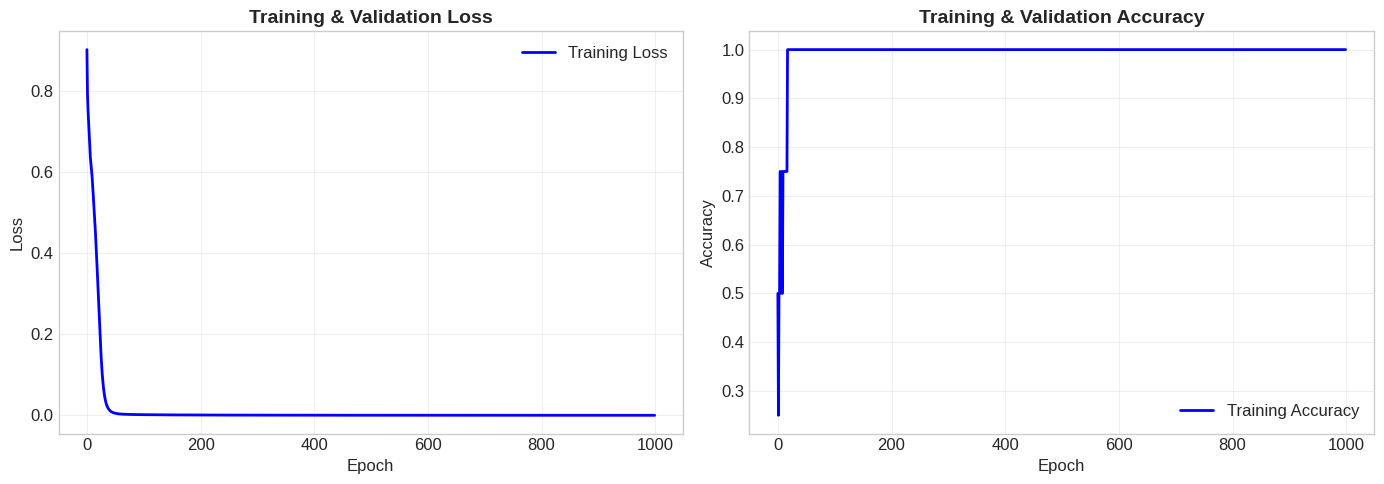

In [ ]:
# ============================================================================
#                         DEMO 1: LEARNING XOR
# ============================================================================

print("\n" + "="*60)
print("              DEMO 1: LEARNING XOR")
print("="*60)

# XOR dataset
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([[0], [1], [1], [0]])

# Create the network
xor_nn = NeuralNetwork(
    loss=BinaryCrossEntropyLoss(),
    optimizer=Adam(learning_rate=0.1)
)

# Architecture: 2 -> 8 -> 1
xor_nn.add(DenseLayer(2, 8, Tanh()))
xor_nn.add(DenseLayer(8, 1, Sigmoid()))

xor_nn.summary()

# Train
print("Training...\n")
history = xor_nn.fit(X_xor, y_xor, epochs=1000, batch_size=4, verbose=True)

# Test predictions
print("\n" + "-"*40)
print("             PREDICTIONS")
print("-"*40)
print(f"{'Input':<15} {'True':<10} {'Predicted':<10} {'Rounded':<10}")
print("-"*40)

predictions = xor_nn.predict(X_xor)
for x, y_true, y_pred in zip(X_xor, y_xor, predictions):
    print(f"{str(x):<15} {y_true[0]:<10} {y_pred[0]:<10.4f} {round(y_pred[0]):<10}")

# Plot training history
xor_nn.plot_history()

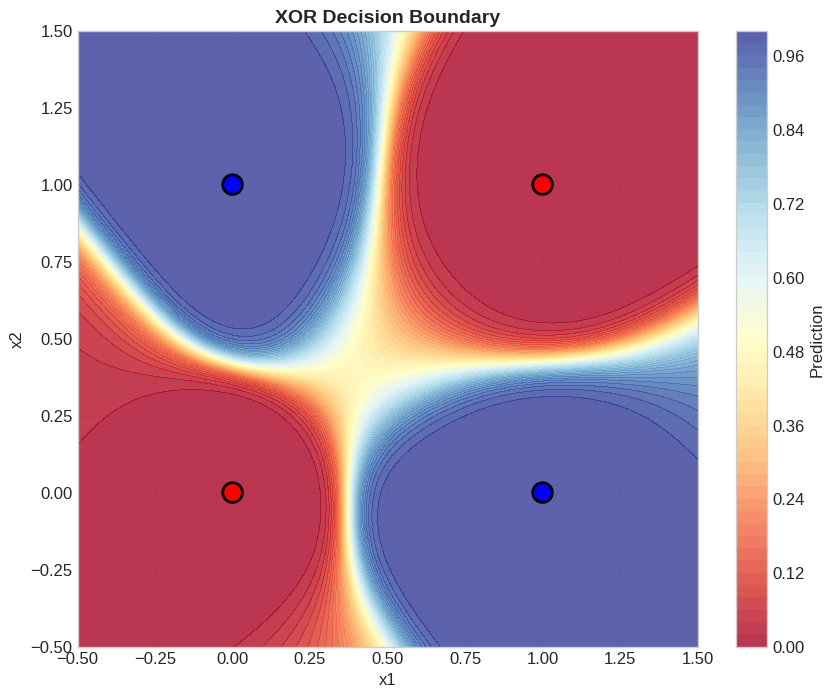


 The network learned to create a non-linear decision boundary!
 Without the hidden layer, this would be impossible.


In [ ]:
# ============================================================================
#                VISUALIZE XOR DECISION BOUNDARY
# ============================================================================

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """
    Visualize how the network partitions the input space.
    """
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict on mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, levels=50, cmap='RdYlBu', alpha=0.8)
    plt.colorbar(label='Prediction')

    # Plot data points
    colors = ['red' if label == 0 else 'blue' for label in y.flatten()]
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=200, edgecolors='black', linewidth=2, zorder=5)

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_decision_boundary(xor_nn, X_xor, y_xor, "XOR Decision Boundary")

print("\n The network learned to create a non-linear decision boundary!")
print(" Without the hidden layer, this would be impossible.")

---

## Demo 2: Binary Classification (Moons Dataset)

Let's try a more challenging problem with the "two moons" dataset.


           DEMO 2: MOONS CLASSIFICATION


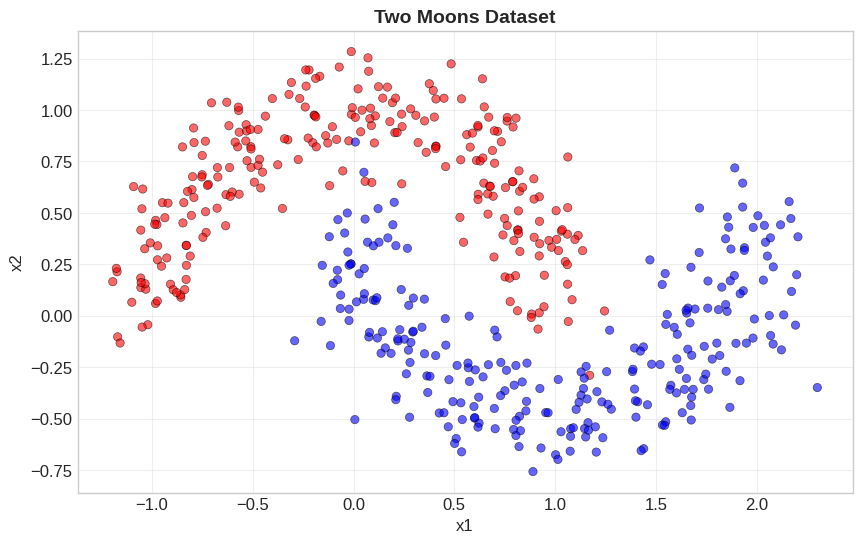


                    NETWORK SUMMARY
Layer 1: DenseLayer(2 -> 16, ReLU)
         Params: 48 (W: (2, 16), b: (1, 16))
Layer 2: DenseLayer(16 -> 16, ReLU)
         Params: 272 (W: (16, 16), b: (1, 16))
Layer 3: DenseLayer(16 -> 1, Sigmoid)
         Params: 17 (W: (16, 1), b: (1, 1))
------------------------------------------------------------
Total Parameters: 337
Loss Function:    BinaryCrossEntropyLoss
Optimizer:        Adam

Training...

Epoch   20/200 | Loss: 0.056926 | Acc: 0.9825 | Val Loss: 0.072926 | Val Acc: 0.9900
Epoch   40/200 | Loss: 0.029531 | Acc: 0.9925 | Val Loss: 0.045036 | Val Acc: 0.9800
Epoch   60/200 | Loss: 0.018276 | Acc: 0.9925 | Val Loss: 0.055494 | Val Acc: 0.9900
Epoch   80/200 | Loss: 0.027489 | Acc: 0.9900 | Val Loss: 0.080128 | Val Acc: 0.9900
Epoch  100/200 | Loss: 0.021971 | Acc: 0.9925 | Val Loss: 0.063574 | Val Acc: 0.9900
Epoch  120/200 | Loss: 0.014455 | Acc: 0.9950 | Val Loss: 0.072885 | Val Acc: 0.9900
Epoch  140/200 | Loss: 0.009760 | Acc: 0.9950 |

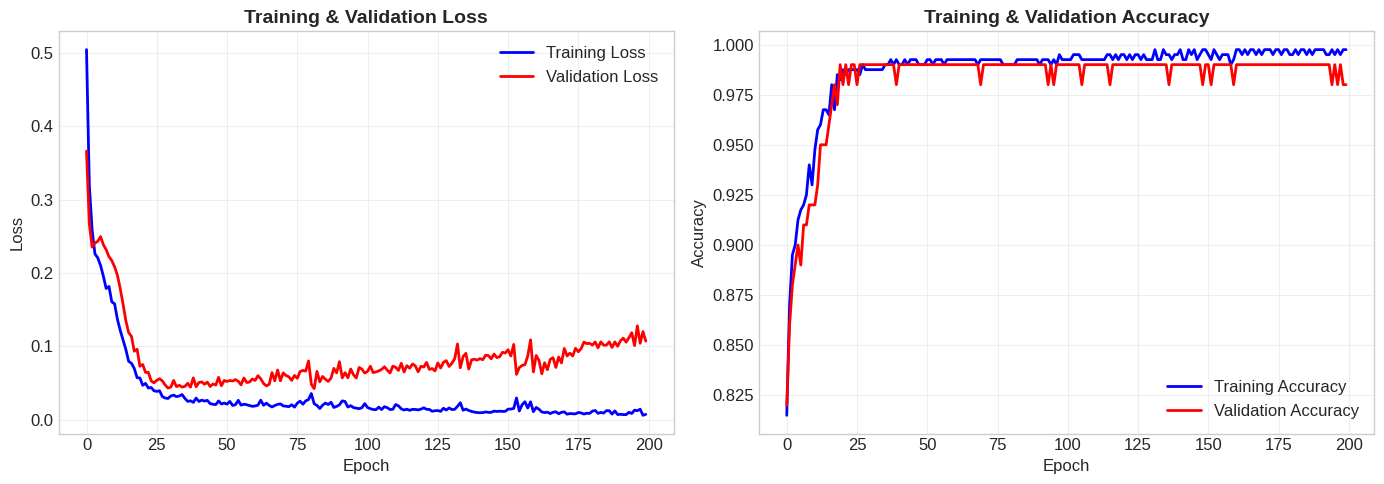

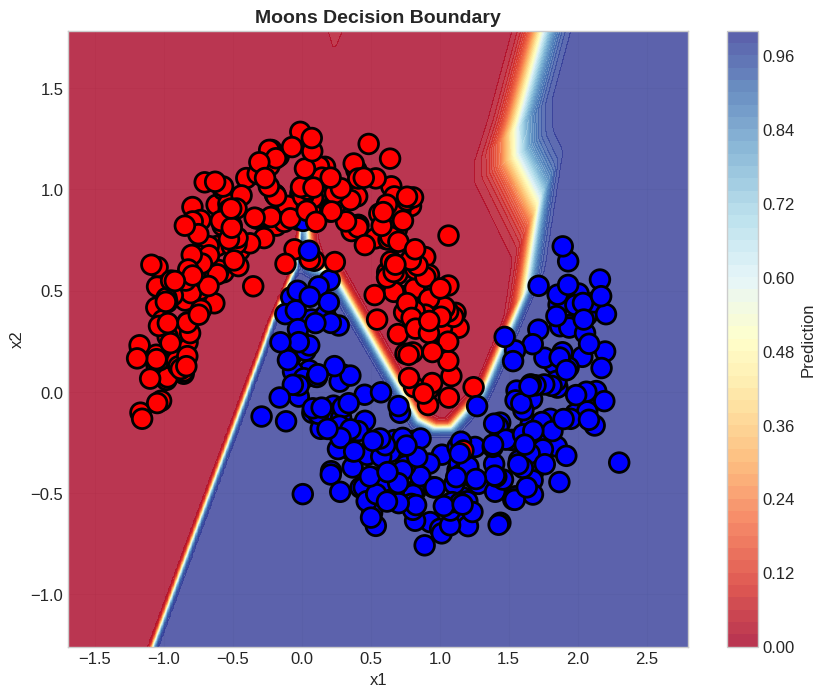

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def make_moons(n_samples=500, noise=0.1):
    """
    Generate two interleaving half circles (moons).
    """
    n_samples_per_class = n_samples // 2

    # First moon (class 0)
    theta1 = np.linspace(0, np.pi, n_samples_per_class)
    x1_moon1 = np.cos(theta1)
    x2_moon1 = np.sin(theta1)

    # Second moon (class 1)
    theta2 = np.linspace(0, np.pi, n_samples_per_class)
    x1_moon2 = 1 - np.cos(theta2)
    x2_moon2 = 0.5 - np.sin(theta2)

    # Combine
    X = np.vstack([
        np.column_stack([x1_moon1, x2_moon1]),
        np.column_stack([x1_moon2, x2_moon2])
    ])

    # Add noise
    X += np.random.randn(*X.shape) * noise

    # Labels
    y = np.array([0] * n_samples_per_class + [1] * n_samples_per_class)

    return X, y.reshape(-1, 1)


print("\n" + "="*60)
print("           DEMO 2: MOONS CLASSIFICATION")
print("="*60)

# Generate data
X_moons, y_moons = make_moons(n_samples=500, noise=0.15)

# Shuffle data
shuffled_indices = np.random.permutation(X_moons.shape[0])
X_moons = X_moons[shuffled_indices]
y_moons = y_moons[shuffled_indices]

# Train/validation split
split_idx = 400
X_train, X_val = X_moons[:split_idx], X_moons[split_idx:]
y_train, y_val = y_moons[:split_idx], y_moons[split_idx:]

# Visualize the data
plt.figure(figsize=(10, 6))
colors = ['red' if label == 0 else 'blue' for label in y_moons.flatten()]
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=colors, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.title('Two Moons Dataset', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# Create network
moon_nn = NeuralNetwork(
    loss=BinaryCrossEntropyLoss(),
    optimizer=Adam(learning_rate=0.01)
)

moon_nn.add(DenseLayer(2, 16, ReLU()))
moon_nn.add(DenseLayer(16, 16, ReLU()))
moon_nn.add(DenseLayer(16, 1, Sigmoid()))

moon_nn.summary()

# Train
print("Training...\n")
history = moon_nn.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=True
)

# Plot results
moon_nn.plot_history()
plot_decision_boundary(moon_nn, X_moons, y_moons, "Moons Decision Boundary")

---

## Demo 3: Multi-Class Classification (Spiral Dataset)

The ultimate test: a 3-class spiral pattern!


          DEMO 3: SPIRAL CLASSIFICATION


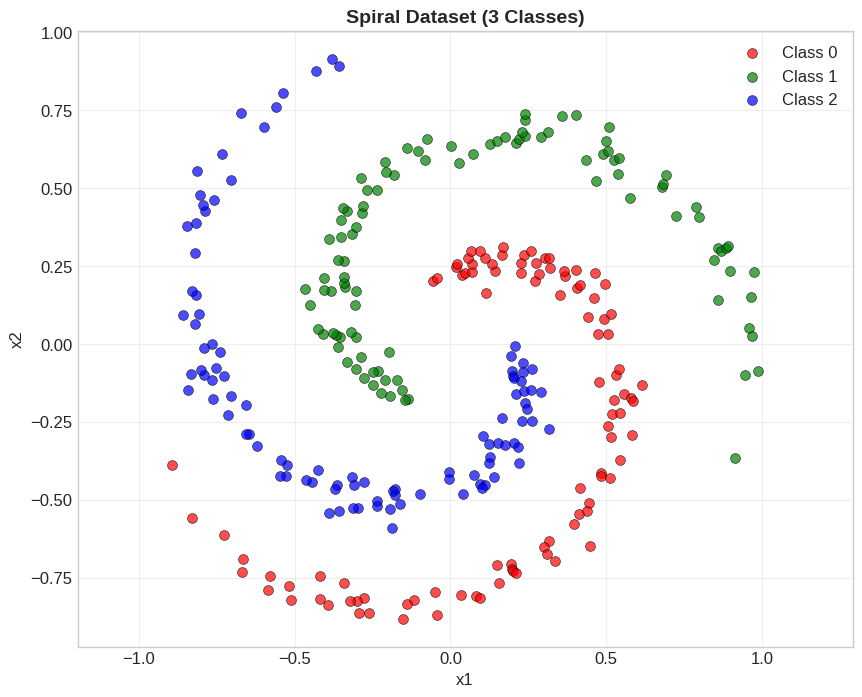


                    NETWORK SUMMARY
Layer 1: DenseLayer(2 -> 64, ReLU)
         Params: 192 (W: (2, 64), b: (1, 64))
Layer 2: DenseLayer(64 -> 32, ReLU)
         Params: 2,080 (W: (64, 32), b: (1, 32))
Layer 3: DenseLayer(32 -> 3, Softmax)
         Params: 99 (W: (32, 3), b: (1, 3))
------------------------------------------------------------
Total Parameters: 2,371
Loss Function:    CategoricalCrossEntropyLoss
Optimizer:        Adam

Training (this may take a moment)...

Epoch   50/500 | Loss: 0.009801 | Acc: 1.0000
Epoch  100/500 | Loss: 0.004858 | Acc: 1.0000
Epoch  150/500 | Loss: 0.002962 | Acc: 1.0000
Epoch  200/500 | Loss: 0.002135 | Acc: 1.0000
Epoch  250/500 | Loss: 0.001705 | Acc: 1.0000
Epoch  300/500 | Loss: 0.001266 | Acc: 1.0000
Epoch  350/500 | Loss: 0.001074 | Acc: 1.0000
Epoch  400/500 | Loss: 0.000866 | Acc: 1.0000
Epoch  450/500 | Loss: 0.000758 | Acc: 1.0000
Epoch  500/500 | Loss: 0.000600 | Acc: 1.0000


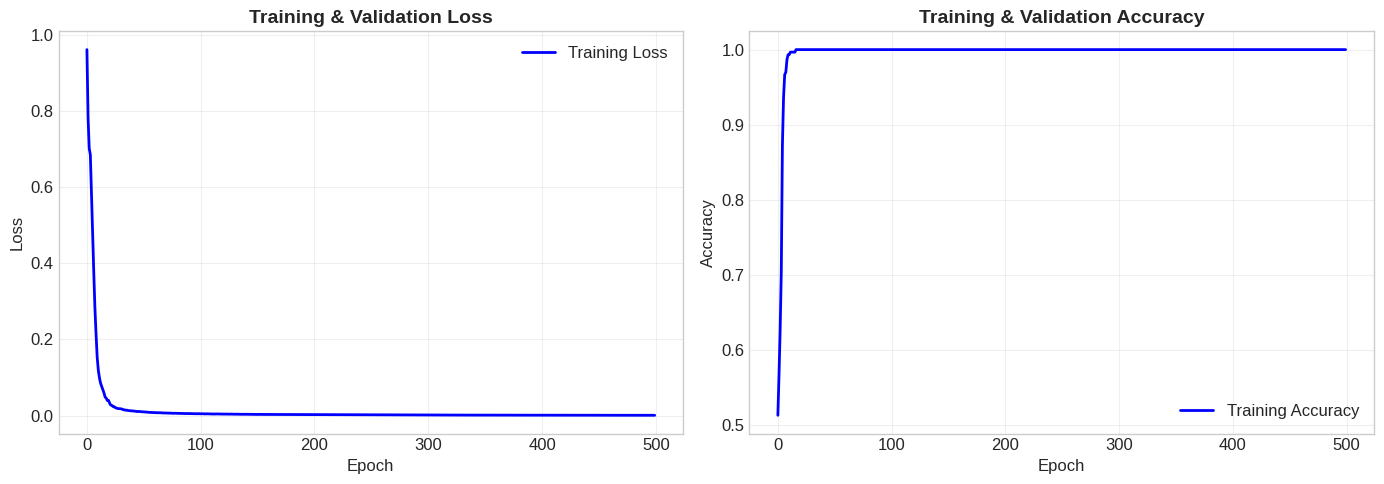

In [ ]:
# ============================================================================
#                   DEMO 3: SPIRAL CLASSIFICATION
# ============================================================================

def make_spiral(n_samples=300, n_classes=3, noise=0.2):
    """
    Generate a spiral dataset with multiple classes.
    """
    X = []
    y = []

    samples_per_class = n_samples // n_classes

    for class_idx in range(n_classes):
        # Create spiral arm
        r = np.linspace(0.2, 1, samples_per_class)
        theta = np.linspace(
            class_idx * 4,
            class_idx * 4 + 4,
            samples_per_class
        ) + np.random.randn(samples_per_class) * noise

        x1 = r * np.sin(theta)
        x2 = r * np.cos(theta)

        X.append(np.column_stack([x1, x2]))
        y.extend([class_idx] * samples_per_class)

    X = np.vstack(X)
    y = np.array(y)

    # One-hot encode
    y_onehot = np.zeros((len(y), n_classes))
    y_onehot[np.arange(len(y)), y] = 1

    return X, y_onehot, y


print("\n" + "="*60)
print("          DEMO 3: SPIRAL CLASSIFICATION")
print("="*60)

# Generate data
X_spiral, y_spiral_onehot, y_spiral_labels = make_spiral(n_samples=300, n_classes=3)

# Visualize
plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
for i in range(3):
    mask = y_spiral_labels == i
    plt.scatter(X_spiral[mask, 0], X_spiral[mask, 1],
                c=colors[i], label=f'Class {i}', alpha=0.7,
                edgecolors='black', linewidth=0.5, s=50)
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.title('Spiral Dataset (3 Classes)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Create network with softmax output
spiral_nn = NeuralNetwork(
    loss=CategoricalCrossEntropyLoss(),
    optimizer=Adam(learning_rate=0.01)
)

spiral_nn.add(DenseLayer(2, 64, ReLU()))
spiral_nn.add(DenseLayer(64, 32, ReLU()))
spiral_nn.add(DenseLayer(32, 3, Softmax()))

spiral_nn.summary()

# Train
print("Training (this may take a moment)...\n")
history = spiral_nn.fit(X_spiral, y_spiral_onehot, epochs=500, batch_size=32, verbose=True)

# Plot training history
spiral_nn.plot_history()

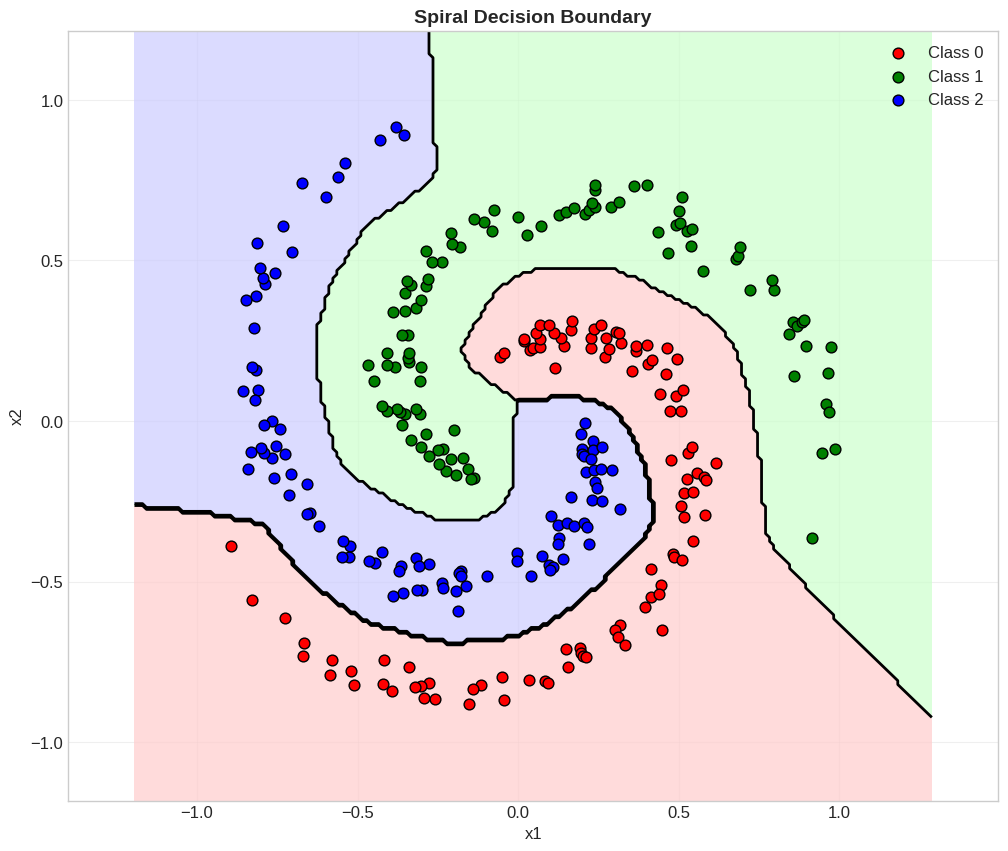


 Final Accuracy: 100.00%


In [ ]:
# ============================================================================
#             VISUALIZE SPIRAL DECISION BOUNDARY
# ============================================================================

def plot_multiclass_boundary(model, X, y_labels, title="Decision Boundary"):
    """
    Visualize multi-class decision boundary.
    """
    # Create mesh
    x_min, x_max = X[:, 0].min() - 0.3, X[:, 0].max() + 0.3
    y_min, y_max = X[:, 1].min() - 0.3, X[:, 1].max() + 0.3
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_classes = np.argmax(Z, axis=1).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(12, 10))
    plt.contourf(xx, yy, Z_classes, levels=[-0.5, 0.5, 1.5, 2.5],
                 colors=['#ffcccc', '#ccffcc', '#ccccff'], alpha=0.7)
    plt.contour(xx, yy, Z_classes, levels=[0.5, 1.5], colors='black', linewidths=2)

    # Plot points
    colors = ['red', 'green', 'blue']
    for i in range(3):
        mask = y_labels == i
        plt.scatter(X[mask, 0], X[mask, 1], c=colors[i], label=f'Class {i}',
                    s=60, edgecolors='black', linewidth=1, zorder=5)

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

plot_multiclass_boundary(spiral_nn, X_spiral, y_spiral_labels, "Spiral Decision Boundary")

# Final accuracy
predictions = spiral_nn.predict(X_spiral)
pred_classes = np.argmax(predictions, axis=1)
accuracy = np.mean(pred_classes == y_spiral_labels)

print(f"\n Final Accuracy: {accuracy * 100:.2f}%")

---

# Chapter 8: The MNIST Challenge

## Real-World Digit Recognition

Let's test our network on MNIST - handwritten digit classification with 28x28 pixel images!


            DEMO 4: DIGIT CLASSIFICATION
Training samples: 1437
Test samples:     360
Input features:   64 (8x8 pixels)
Output classes:   10 digits (0-9)


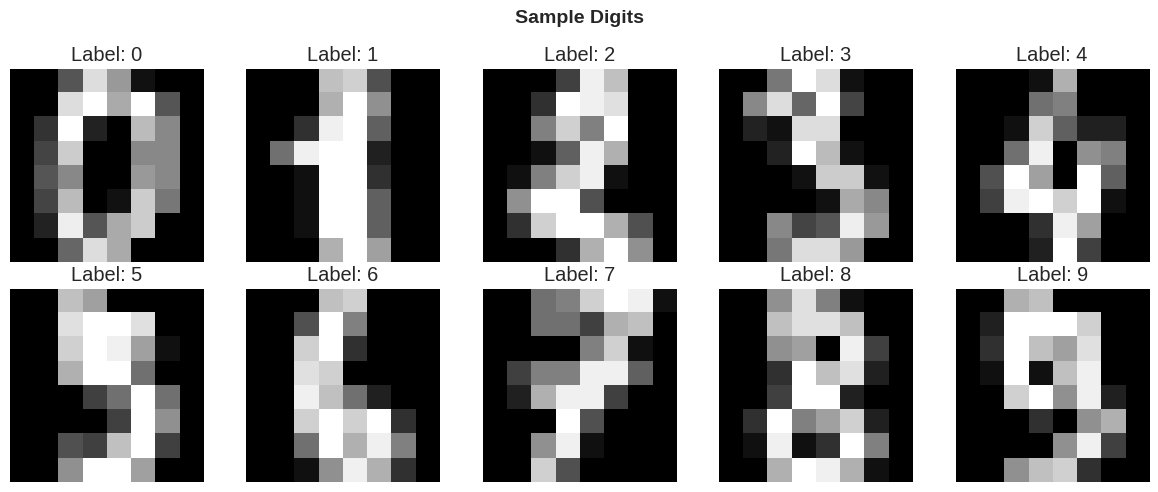


                    NETWORK SUMMARY
Layer 1: DenseLayer(64 -> 128, ReLU)
         Params: 8,320 (W: (64, 128), b: (1, 128))
Layer 2: DenseLayer(128 -> 64, ReLU)
         Params: 8,256 (W: (128, 64), b: (1, 64))
Layer 3: DenseLayer(64 -> 10, Softmax)
         Params: 650 (W: (64, 10), b: (1, 10))
------------------------------------------------------------
Total Parameters: 17,226
Loss Function:    CategoricalCrossEntropyLoss
Optimizer:        Adam

Training...

Epoch   10/100 | Loss: 0.044671 | Acc: 0.9958 | Val Loss: 0.115403 | Val Acc: 0.9639
Epoch   20/100 | Loss: 0.012534 | Acc: 1.0000 | Val Loss: 0.108970 | Val Acc: 0.9694
Epoch   30/100 | Loss: 0.007456 | Acc: 1.0000 | Val Loss: 0.106649 | Val Acc: 0.9722
Epoch   40/100 | Loss: 0.005318 | Acc: 1.0000 | Val Loss: 0.106048 | Val Acc: 0.9722
Epoch   50/100 | Loss: 0.004081 | Acc: 1.0000 | Val Loss: 0.106029 | Val Acc: 0.9722
Epoch   60/100 | Loss: 0.003229 | Acc: 1.0000 | Val Loss: 0.106361 | Val Acc: 0.9722
Epoch   70/100 | Loss: 

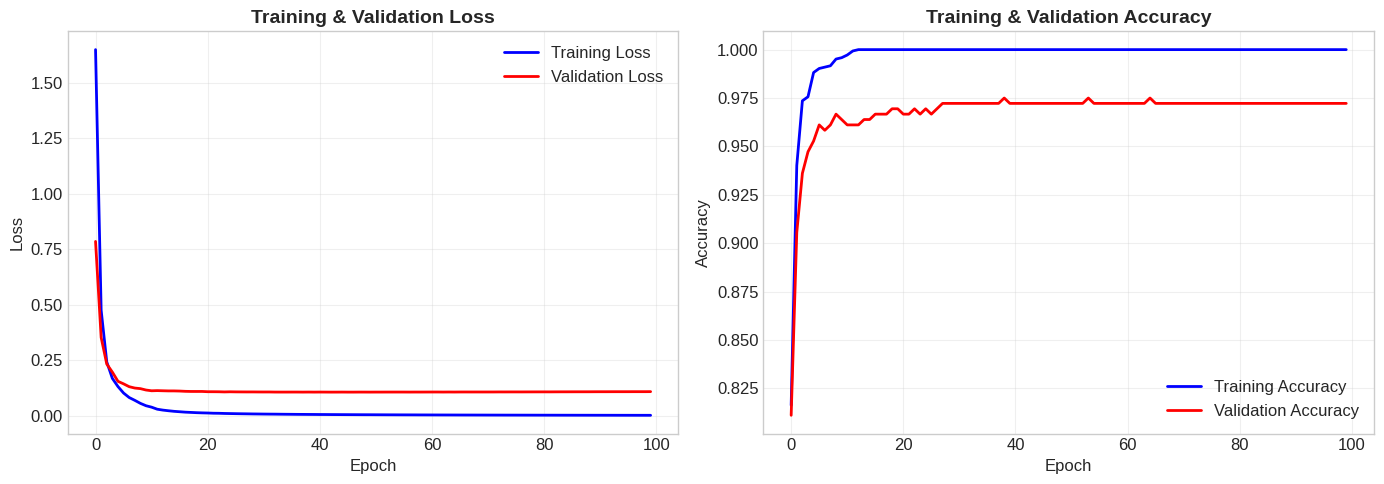


 Test Accuracy: 97.22%


In [ ]:
# ============================================================================
#                        DEMO 4: MNIST DIGITS
# ============================================================================

def load_mnist_sample():
    """
    Load a subset of MNIST for demonstration.
    We'll use sklearn's digits dataset as a simpler alternative.
    """
    from sklearn.datasets import load_digits
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # Load digits (8x8 images, 10 classes)
    digits = load_digits()
    X, y = digits.data, digits.target

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # One-hot encode
    n_classes = 10
    y_onehot = np.zeros((len(y), n_classes))
    y_onehot[np.arange(len(y)), y] = 1

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_onehot, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test, y


print("\n" + "="*60)
print("            DEMO 4: DIGIT CLASSIFICATION")
print("="*60)

# Load data
X_train, X_test, y_train, y_test, y_labels = load_mnist_sample()

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")
print(f"Input features:   {X_train.shape[1]} (8x8 pixels)")
print(f"Output classes:   10 digits (0-9)")

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Sample Digits', fontsize=14, fontweight='bold')

from sklearn.datasets import load_digits
digits = load_digits()

for i, ax in enumerate(axes.flatten()):
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Label: {digits.target[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Create network
digit_nn = NeuralNetwork(
    loss=CategoricalCrossEntropyLoss(),
    optimizer=Adam(learning_rate=0.001)
)

digit_nn.add(DenseLayer(64, 128, ReLU()))
digit_nn.add(DenseLayer(128, 64, ReLU()))
digit_nn.add(DenseLayer(64, 10, Softmax()))

digit_nn.summary()

# Train
print("Training...\n")
history = digit_nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=True
)

# Plot history
digit_nn.plot_history()

# Final evaluation
test_pred = digit_nn.predict(X_test)
test_classes = np.argmax(test_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_classes == true_classes)

print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")

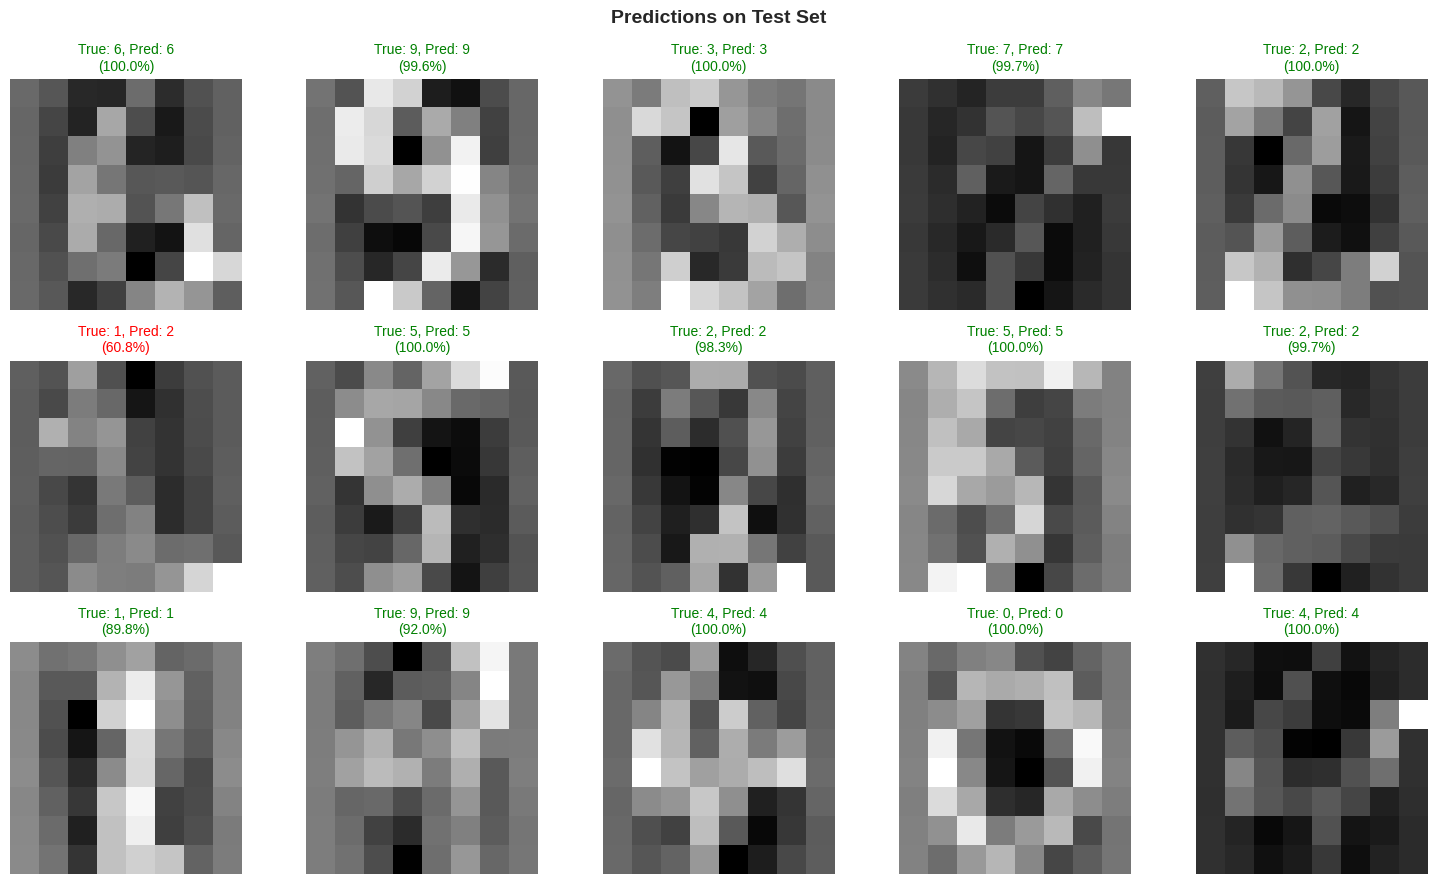

 Green = Correct, Red = Incorrect


In [ ]:
# ============================================================================
#                     VISUALIZE PREDICTIONS
# ============================================================================

# Show some predictions
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Predictions on Test Set', fontsize=14, fontweight='bold')

# Get test predictions
test_predictions = digit_nn.predict(X_test)

for i, ax in enumerate(axes.flatten()):
    # Get image
    img = X_test[i].reshape(8, 8)
    true_label = np.argmax(y_test[i])
    pred_label = np.argmax(test_predictions[i])
    confidence = test_predictions[i][pred_label] * 100

    # Display
    ax.imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}\n({confidence:.1f}%)',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(" Green = Correct, Red = Incorrect")

---

# Conclusion: What We Built

## From Scratch to Deep Learning

Congratulations! You've built a complete neural network framework using only NumPy.

### Components We Implemented

| Component | Purpose |
|-----------|--------|
| **Activation Functions** | Sigmoid, Tanh, ReLU, LeakyReLU, Softmax |
| **Loss Functions** | MSE, Binary Cross-Entropy, Categorical Cross-Entropy |
| **Dense Layer** | Fully connected layer with forward & backward pass |
| **Optimizers** | SGD with Momentum, Adam |
| **Neural Network** | Complete training pipeline |

### Key Takeaways

1. **Forward Pass**: Data flows through layers, applying linear transformations + activations
2. **Backpropagation**: Gradients flow backward using the chain rule
3. **Gradient Descent**: Weights are updated to minimize loss
4. **Non-linearity**: Activation functions enable learning complex patterns
5. **Batching**: Processing data in mini-batches improves efficiency

### Where to Go From Here

- **Regularization**: L1/L2 regularization, Dropout
- **Batch Normalization**: Stabilize and accelerate training
- **Convolutional Layers**: For image processing
- **Recurrent Layers**: For sequence data
- **Modern Architectures**: Transformers, ResNets

---

*"The best way to understand something is to build it."*

**Happy Learning!**

In [ ]:
# ============================================================================
#                            BONUS: PLAYGROUND
# ============================================================================
# Try creating your own network! Experiment with:
# - Different architectures (more/fewer layers, neurons)
# - Different activation functions
# - Different optimizers and learning rates
# ============================================================================

print("\n" + "="*60)
print("                  PLAYGROUND")
print("="*60)
print("\nTry creating your own network! Example:")
print()
print("my_nn = NeuralNetwork(")
print("    loss=MSELoss(),")
print("    optimizer=Adam(learning_rate=0.001)")
print(")")
print("my_nn.add(DenseLayer(2, 32, ReLU()))")
print("my_nn.add(DenseLayer(32, 16, ReLU()))")
print("my_nn.add(DenseLayer(16, 1, Sigmoid()))")
print("my_nn.summary()")
print()
print(" Experiment and have fun!")


                  PLAYGROUND

Try creating your own network! Example:

my_nn = NeuralNetwork(
    loss=MSELoss(),
    optimizer=Adam(learning_rate=0.001)
)
my_nn.add(DenseLayer(2, 32, ReLU()))
my_nn.add(DenseLayer(32, 16, ReLU()))
my_nn.add(DenseLayer(16, 1, Sigmoid()))
my_nn.summary()

 Experiment and have fun!
